In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def preprocessing_dense(train_x, train_y, test_x, test_y):
    # data Normalization
    train_x = train_x / 255.
    test_x = test_x / 255.
    
    # one hot encoding the train and test labels
    enc = OneHotEncoder(sparse=False, categories='auto')
    train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))
    test_y = enc.transform(test_y.reshape(len(test_y), -1))
    
    #dividing the data into batches
    m_x,l_x = train_x.shape
    m_y,l_y = train_y.shape
    train_x = train_x.reshape(60,int(m_x/60),l_x)
    test_x = test_x.reshape(60,int(m_x/60),l_x)
    train_y = train_y.reshape(60,int(m_y/60),l_y)
    test_y = test_y.reshape(60,int(m_y/60),l_y)
 
    return train_x, train_y, test_x, test_y
def preprocessing_conv(train_x, train_y, test_x, test_y):
    # data Normalization
    m = train_x.shape[0]
    m1 = test_x.shape[0]
    train_x = np.reshape(train_x,(m,28,28,1))
    test_x = np.reshape(test_x,(m1,28,28,1))
    train_x = train_x / 255.
    test_x = test_x / 255.
     # one hot encoding the train and test labels
    enc = OneHotEncoder(sparse=False, categories='auto')
    train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))
    test_y = enc.fit_transform(test_y.reshape(len(test_y), -1))
    
    #dividing the data into batches
    m_x,a,b,l_x = train_x.shape
    m_y,l_y = train_y.shape
    train_x = train_x.reshape(60,int(m_x/60),a,b,l_x)
    test_x = test_x.reshape(60,int(m_x/60),a,b,l_x)
    train_y = train_y.reshape(60,int(m_y/60),l_y)
    test_y = test_y.reshape(60,int(m_y/60),l_y)
 
    return train_x, train_y, test_x, test_y
 

In [ ]:
def sigmoid(Z): #sigmoid activation
    return 1 / (1 + np.exp(-Z))
def softmax(Z):  #softmax activation
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)
def sigmoid_derivative(Z):  #sigmoid activation derivative
    s = 1 / (1 + np.exp(-Z))
    return s * (1 - s)
def relu(Z):  #relu activation
    return np.maximum(0,Z)
def relu_derivative(Z):  #relu activation derivative
    a= relu(Z)
    a[a>0] = 1
    a[a<0] = 0
    return a


In [4]:
class Dense:
    def __init__(self, dense_architecture): # fully connected network constructor 
        self.dense_architecture = list(dense_architecture) # passing the the architecture
        self.parameters = self.init_params(self.dense_architecture) # intializing parameters according to the structure
        self.cost_hist = []
        self.acc_hist = []
 
    def init_params(self,dense_architecture):
        np.random.seed(2) # fixing seed to avoid complete randomness
        
        params = {} #dictionary for weights and biases
        
        for i, layer in enumerate(dense_architecture): #looping over architecture list to initiate parameters
            idx = i + 1  # we begin W and b from 1 because  layer0= input_layer 
            
            #picking W and b matrix dims from architecture
            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]
            
           #initiating the values of the W matrix and b with random values and normalizing them
            params['W' + str(idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.01 #keeping parameters small
            params['b' + str(idx)] = np.random.randn(layer_output_size, 1) *0.01
        return params
    def forward_step(self,W,X,b,activation):
        Z = W.dot(X)+b #linear feed forward step 
        if activation == "relu":
            A = relu(Z) # applying activation
        elif activation == "sigmoid":
            A= sigmoid(Z) # applying activation
        elif activation == "softmax":
            A = softmax(Z) # applying activation
        else: 
            print("this activation is not supported")
        return A,Z
 
    def forward(self, X):
        cache = {}
 
        A = X.T
        for i,layer in enumerate(self.dense_architecture):
            W = self.parameters["W" + str(i + 1)] #fetching paramters for a specific layer from paramters dictionary 
            b = self.parameters["b" + str(i + 1)]
            activation = layer["activation"]
            A , Z = self.forward_step(W,A,b,activation) #performing the feeed forward step
            # saving results and inputs for back propagation
            cache["A" + str(i + 1)] = A
            cache["W" + str(i + 1)] = self.parameters["W" + str(i + 1)]
            cache["Z" + str(i + 1)] = Z
 
        return A, cache
 
    def log_loss(self,Y,Y_hat): # log loss cost function
        return -np.mean(Y * np.log(Y_hat.T+ 1e-8))
    def log_loss_derivative(self,Y,Y_hat,A_prev,W): # log loss cost derivative with respect to softmax
        m= Y.shape[0]
        dZ = Y_hat - Y.T
 
        dW = dZ.dot(A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = W.T.dot(dZ)
        return dA_prev,dW,db
    
    def backward(self, X, Y, cache): #backpropagation
        m = X.shape[0]
        gradients = {}
 
        cache["A0"] = X.T
 
        Y_hat = cache["A" + str(len(self.dense_architecture))]
        A_prev = cache["A" + str(len(self.dense_architecture) - 1)]
        W = cache["W" + str(len(self.dense_architecture))]
        dA_prev, dW,db = self.log_loss_derivative(Y,Y_hat,A_prev,W)
 
        gradients["dW" + str(len(self.dense_architecture))] = dW
        gradients["db" + str(len(self.dense_architecture))] = db
        archi= list(reversed(self.dense_architecture))
        archi.pop(0)
        for l,layer in enumerate(archi):
            i= len(archi)-l
            if layer["activation"] == "sigmoid":
                dZ = dA_prev * sigmoid_derivative(cache["Z" + str(i)])
            elif layer["activation"] == "relu":
                dZ = dA_prev * relu_derivative(cache["Z" + str(i)])
            else:
                print("unknown derivative")
            dW = (1/ m) * dZ.dot(cache["A" + str(i - 1)].T)
            db = (1/ m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = cache["W" + str(i)].T.dot(dZ)
 
            gradients["dW" + str(i)] = dW
            gradients["db" + str(i)] = db
 
        return gradients,dA_prev
 
    def update(self,derivatives,lr): # updating parameteres according to learning rate and gradients
        for l in range(1, len(self.dense_architecture) + 1):
            self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - lr * derivatives["dW" + str(l)]
            self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - lr * derivatives["db" + str(l)]
            
    def train(self, X, Y, n_iterations=2500,lr=0.01,disp = False): #independent train function for fully connected layers
        for ep in range(n_iterations):
            m = ep%60 #selecting batch
            Y_hat, cache = self.forward(X[m]) #forward propagation
            cost = self.log_loss(Y[m],Y_hat)
            derivatives,dA_prev = self.backward(X[m], Y[m], cache) #back propagation
            self.update(derivatives,lr) #updating parameters
            acc = self.accuracy(Y[m], Y_hat) # checki accuracy by comparing Y_hat and labels 
            self.acc_hist.append(acc) # maintaining cost and accuracy history
            self.cost_hist.append(cost)
            if ep % 10 == 0 and disp == True:
                print("epoch: ",ep," Cost: ", cost, " Train Accuracy:", acc)
            
        
        return dA_prev,self.cost_hist,self.acc_hist
    def dtrain(self, X, Y,lr):# train function utility for CNN one flow through fully connected layers
        Y_hat, cache = self.forward(X)
        cost = self.log_loss(Y,Y_hat)
        derivatives,dA_prev = self.backward(X, Y, cache)
        self.update(derivatives,lr)
        acc = self.accuracy(Y, Y_hat)
        
        return dA_prev,cost,acc
    def accuracy(self,Y,Y_hat): # measures accuray by comparing y and y_hat
        y_hat = np.argmax(Y_hat, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100
 
 

 


In [ ]:
class Convolution:
    conv_achitecture = []
    conv_params = {}
    conv_grads = {}
    conv_memory = {}
    def __init__(self,architecture): #constructor initializing paramters by passing architecture to init_conv2d 
        self.conv_achitecture = architecture
        self.conv_params =self.init_conv2d(architecture,2) #architecture and seed passed
        return
    def init_conv2d(self,conv_architecture,seed=99):
        np.random.seed(seed)
        conv_matrix = {}
        for i,layer in enumerate(conv_architecture):
            layer_i=i+1
            if layer["Type"] == "pool":
                None
            else:
                f1,f2=layer["f"]
                n_C_prev=layer["input_channels"]
                n_C=layer["nof_filters"]

                conv_matrix['W' + str(layer_i)]=np.zeros((f1, f2, n_C_prev, n_C))
                conv_matrix['b' + str(layer_i)]=np.zeros((1,1,1, n_C))
        
        for i in range(0,len(conv_architecture)):
            if conv_architecture[i]["Type"]=="conv":
                print("W",i+1,": ",conv_matrix['W' + str(i+1)].shape," b",i+1,": ",conv_matrix['b' + str(i+1)].shape)

        return conv_matrix
    def padding(self,X, pad):
        # performing padding
        X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode= 'constant', constant_values=(0,0))
    
        return X_pad
    def single_forward_convolution(self,A_slice, W, b): 
    #     linear step forward
        if A_slice.shape == W.shape:
            Zp= np.multiply(A_slice,W)
            Z=np.sum(Zp)    
            b=b.astype(float)
            Z=np.add(Z,b)
            return Z
        else:

            print("dimension dont match",A_slice.shape,W.shape)
            return 0
    def forward_convolution(self,A_prev, W, b, hparameters): # convolving the image with filters convolution one step
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        (f, f, n_C_prev, n_C) = W.shape

        stride = hparameters['stride']
        pad = hparameters['pad']
        n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
        n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
        Z = np.zeros((m, n_H, n_W, n_C))
        A_prev_pad = self.padding(A_prev, pad)

        for i in range(m):     #selecting an image from data          
            a_prev_pad = A_prev_pad[i]   
            for h in range(n_H):   # selecting hieght(y) coordinates to apply filter on image       
                vert_start = h*stride
                vert_end = vert_start+f

                for w in range(n_W): # selecting width(x) coordinates to apply filter on image     
                    horiz_start = w*stride
                    horiz_end = horiz_start+f

                    for c in range(n_C):   #processing a single channel at a time
                        
                        a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                        weights = W[...,c]
                        biases = b[...,c]
                        Z[i, h, w, c] = self.single_forward_convolution(a_slice_prev,weights ,biases )
        # preserving details for backpropagation
        cache = (A_prev, W, b, hparameters)

        return Z, cache
    def convolution_forward_prop(self,X):#complete forward convolution through architecture 
        Z_curr = X
        
        hyperparameter={}
        self.conv_memory["A0"]=X # input saved as A0 for backpropagation
        for idx,layer in enumerate(self.conv_achitecture):
            layer_idx = idx+1 #parameters layers labeled from 1 onwards hence idx+1
            A_prev=Z_curr # current A_prev(input) is previous Z (output) 
            if layer["Type"] == "conv": #for convolution layer
                #fetchig parametres from dictionary
                hyperparameters={'pad':layer["pad"],'stride':layer["stride"]}
                W_curr = self.conv_params["W" + str(layer_idx)]
                b_curr = self.conv_params["b" + str(layer_idx)]
                # performing forward convolution 
                Z_curr,cache_curr = self.forward_convolution(A_prev, W_curr, b_curr, hyperparameters)
                #saving result and inputs for back[ropagation]
                self.conv_memory["cache"+str(layer_idx)] = cache_curr
                self.conv_memory["Z" + str(layer_idx)] = Z_curr
            else: # for pooling layer
                hyperparameters={'f':layer["f"],'pad':layer["pad"],'stride':layer["stride"],'mode':layer["mode"]}
                A_curr,cache_curr=self.pool_forward(A_prev,hyperparameters)
                self.conv_memory["cache"+str(layer_idx)] = cache_curr
                self.conv_memory["Z" + str(layer_idx)] = Z_curr


        return Z_curr
    
    def conv_backward(self,dZ, cache):

        (A_prev, W, b, hparameters)=cache # retrive parameters from cache 
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        stride= hparameters["stride"]
        pad= hparameters["pad"]
        (f, f, n_C_prev, n_C) = W.shape

        (m, n_H, n_W, n_C) = dZ.shape
        # initialize an output similar to previous layer Activation, weights,biases shape with zeros
        dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
        dW = np.zeros((f, f, n_C_prev, n_C))
        db = np.zeros((1, 1, 1, n_C))
        #perform padding to match the shape 
        A_prev_pad = self.padding(A_prev, pad)
        dA_prev_pad = self.padding(dA_prev, pad)

        for i in range(m):                      #select an example from data

            a_prev_pad = A_prev_pad[i]
            da_prev_pad = dA_prev_pad[i]

            for h in range(n_H):       # selecting hieght(y) coordinates to apply filter on image

                v_start = h * stride
                v_end = v_start + f         

                for w in range(n_W): # selecting width(x) coordinates to apply filter on image

                    h_start = w * stride
                    h_end = h_start + f

                    for c in range(n_C):  #iterating through channels   

                        a_slice = a_prev_pad[v_start:v_end, h_start:h_end, :]

                        # Update gradients for the filters 

                        da_prev_pad[v_start:v_end, h_start:h_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                        dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                        db[:,:,:,c] += dZ[i, h, w, c]
            #if pad then pass complete derivative including pad else just derivative 
            if pad>0:
                dA_prev[i, :, :, :] =  da_prev_pad[pad:-pad, pad:-pad, :]
            else:
                dA_prev[i, :, :, :] =  da_prev_pad[:, :, :]


        return dA_prev, dW, db
    
    def pool_forward(self,A_prev, hparameters):
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

        f = hparameters["f"][0]
        stride = hparameters["stride"]
        mode=hparameters["mode"]

        n_H = int(1 + (n_H_prev - f) / stride)
        n_W = int(1 + (n_W_prev - f) / stride)
        n_C = n_C_prev

        A = np.zeros((m, n_H, n_W, n_C))              

        for i in range(m):
            for h in range(n_H):
                vert_start = h*stride
                vert_end = vert_start+f

                for w in range(n_W):
                    horiz_start = w*stride
                    horiz_end = horiz_start + f

                    for c in range (n_C):
                        a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                        if mode == "max":
                            A[i, h, w, c] = np.max(a_prev_slice) #applying a max value mask
                        elif mode == "average":
                            A[i, h, w, c] = np.mean(a_prev_slice)#applying a avg value mask
        cache = (A_prev, hparameters)
        return A, cache
    def max_pool(self,x):
        #mask is equal to the  max value found in x
        mask = x == np.max(x)
        return mask
    def avg_pool(self,dz, shape):
        print(len(dz))
        (n_H, n_W) = shape
        average = dz / (n_H * n_W)
        average = average.reshape(shape)
        a = np.ones(shape) * average    
        return a
    def pool_backward(self,dA,cache, mode = "max"):

        (A_prev, hparameters) = cache
        stride = hparameters["stride"]
        f = hparameters["f"]
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        m, n_H, n_W, n_C = dA.shape
        dA_prev = np.zeros(A_prev.shape)

        for i in range(m):  
            a_prev = A_prev[i]

            for h in range(n_H):
                v_start = h
                v_end = v_start + f[0]
                for w in range(n_W):
                    h_start = w
                    h_end = h_start + f[0]
                    for c in range(n_C):           
                        if mode == "max":
                            a_prev_slice = a_prev[v_start:v_end, h_start:h_end, c]
                            mask = self.max_pool(a_prev_slice)
                            dA_prev[i, v_start: v_end, h_start: h_end, c] += np.multiply(mask, dA[i, h, w, c])
                        elif mode == "avg":
                            da = dA[i, h, w, c]
                            
                            dA_prev[i, v_start: v_end, h_start: h_end, c] += self.avg_pool(da, f)



        return dA_prev
    def convolution_backward_prop(self,dz):
        dA_prev=dz
        for layer_idx_prev,layer in reversed(list(enumerate(self.conv_achitecture))):
            layer_idx_curr = layer_idx_prev + 1
            dA_curr = dA_prev
            cache = self.conv_memory["cache" + str(layer_idx_curr)]

            if layer["Type"] == "conv":
                Z_curr= self.conv_memory["Z" + str(layer_idx_curr)]

                dA_prev,dW,db = self.conv_backward(dA_curr,cache)
                self.conv_grads["dW"+str(layer_idx_curr)]= dW
                self.conv_grads["db"+str(layer_idx_curr)]= db
            else:
                dA_prev = self.pool_backward(dA_curr, cache, mode = layer["mode"])

        return dA_prev
    def update_parameters(self,learning_rate):
        for idx in range(int(len(self.conv_params)/2)):
            self.conv_params["W" + str(idx+1)] -= learning_rate * self.conv_grads["dW" + str(idx+1)]        
            self.conv_params["b" + str(idx+1)] -= learning_rate * self.conv_grads["db" + str(idx+1)] 
    
    
        

In [ ]:
def ttrain( X, Y, conv_arch,dense_arch,lr=0.01, epochs=2500):
    conv = Convolution(conv_arch)
    dense = Dense(dense_architecture)
    cost_hist =[]
    accuracy_hist = []
    for e in range(epochs):

        A_curr = conv.convolution_forward_prop(X)
        
        (a_m,a_h,a_w,a_c) = A_curr.shape
        x_dense = np.reshape(A_curr,(a_m,(a_h*a_w*a_c)))
        x_out,cost,acc = dense.dtrain(x_dense,Y,1,lr,True)
        
        dA_prev=np.reshape(x_out.T,(A_curr.shape))
        prev = conv.convolution_backward_prop(dA_prev)
        conv.update_parameters(lr)
        cost_hist.append(cost)
        accuracy_hist.append(acc)
        print("epoch: ",e,"- cost: ",cost,"accuracy: ", acc)
    
    return cost_hist,acc_hist
        

In [ ]:

def costPlot(cost_hist): #utility to plot cost
    plt.figure()
    plt.plot(np.arange(len(cost_hist)), cost_hist)
    plt.xlabel("epochs")
    plt.ylabel("cost")
    plt.show()

# Main

In [8]:
# retriving data
from mlxtend.data import loadlocal_mnist
X, y = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')
X_test,y_test = loadlocal_mnist(
        images_path='t10k-images.idx3-ubyte', 
        labels_path='t10k-labels.idx1-ubyte')


Populating the interactive namespace from numpy and matplotlib


C:\Users\DELL\Anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


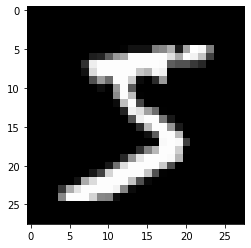

In [9]:
%pylab inline
import matplotlib.pyplot as plt
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.show()

In [10]:
print("above picture represents a: ",y[0])

above picture represents a:  5


# implementing a simple feed forward forward network on MNIST data 

In [98]:
train_x = X
train_y= y
test_x = X_test
test_y = y_test
train_x, train_y, test_x, test_y = preprocessing_dense(train_x, train_y, test_x, test_y)

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

(60000, 784) (60000, 10)
train_x's shape: (60, 1000, 784)
test_x's shape: (60, 1000, 784)


In [103]:
dense_architecture=[
    {"input_dim": 784, "output_dim": 50, "activation": "sigmoid"},
        {"input_dim": 50, "output_dim": 10, "activation": "softmax"}
    ]
ann = Dense(dense_architecture)

da_prev,cost_hist,acc_hist = ann.train(train_x, train_y, lr=0.1, n_iterations=1000)



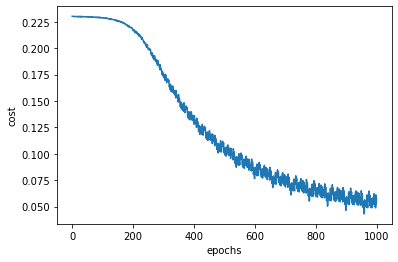

In [104]:
costPlot(cost_hist)

# implementing a CNN on MNIST data

In [11]:
train_x = X
train_y= y
test_x = X_test
test_y = y_test
train_x, train_y, test_x, test_y = preprocessing_conv(train_x, train_y, test_x, test_y)

In [ ]:
#specify both architectures
conv_architecture=[
    {"input_channels":1 ,"f":(3,3),"nof_filters":28,"stride":2,"pad":0,"Type":"conv"},
    {"input_channels":28 ,"f":(3,3),"nof_filters":10,"stride":1,"pad":0,"Type":"conv"}
]
dense_architecture=[
    {"input_dim":1210 , "output_dim": 50, "activation": "sigmoid"},
        {"input_dim": 50, "output_dim": 10, "activation": "softmax"}
    ]
# cost,acc =ttrain(train_x, train_y, conv_architecture,dense_architecture,0.1, 100)
epochs= 100
lr = 0.1
conv = Convolution(conv_architecture)
dense = Dense(dense_architecture)
cost_hist =[]
accuracy_hist = []
for e in range(epochs):
    b = e%60
    A_curr = conv.convolution_forward_prop(train_x[b])
    
    (a_m,a_h,a_w,a_c) = A_curr.shape
    x_dense = np.reshape(A_curr,(a_m,(a_h*a_w*a_c)))
    x_out,cost,acc = dense.dtrain(x_dense,train_y[b],lr)
    
    dA_prev=np.reshape(x_out.T,(A_curr.shape))
    print(dA_prev.shape)
    prev = conv.convolution_backward_prop(dA_prev)
    conv.update_parameters(lr)
    cost_hist.append(cost)
    accuracy_hist.append(acc)
    print("epoch: ",e,"- cost: ",cost,"accuracy: ", acc)
    

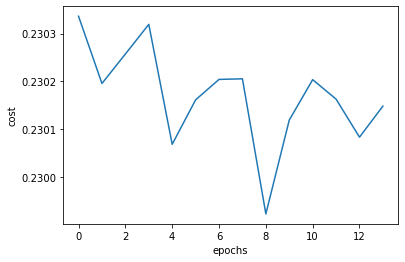

In [15]:
costPlot(cost_hist)